In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:

class particle():
    def __init__(self, mass, x0, v0):
        self.mass = mass
        self.x0 = x0
        self.v0 = v0

        self.x = x0
        self.v = v0

    def energy(self, v):
        return 0.5 * self.mass * np.linalg.norm(v) ** 2

    def momentum(self):
        return self.mass * self.velocity

class spring():
    def __init__(self, k, x0, v0):
        self.k = k
        self.x0 = x0
        self.v0 = v0

    def energy(self, x):
        return 0.5 * self.k * (x - self.x0) ** 2


In [4]:

def euler_integration(particle, force, t_max, dt = 0.001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []

    for t in t_array:
        particle.x = particle.x + particle.v * dt
        particle.v = particle.v + force(particle) / particle.mass * dt

        pos.append(particle.x)
        vel.append(particle.v)
        
    return np.array(pos), np.array(vel)


def verlet_integrate(particle, force, t_max, dt = 0.001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []
    for t in t_array:
        particle.x = particle.x + particle.v * dt + 0.5 * force(particle) / particle.mass * dt ** 2
        particle.v = particle.v + force(particle) / particle.mass * dt
        pos.append(particle.x)
        vel.append(particle.v)
        
    return np.array(pos), np.array(vel)


def runge_kutta(particle, force, t_max, dt = 0.00001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []
    for t in t_array:
        k1 = particle.v
        l1 = force(particle) / particle.mass
        k2 = particle.v + l1 * dt / 2
        l2 = force(particle) / particle.mass
        k3 = particle.v + l2 * dt / 2
        l3 = force(particle) / particle.mass
        k4 = particle.v + l3 * dt
        l4 = force(particle) / particle.mass
        particle.x = particle.x + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6
        particle.v = particle.v + (l1 + 2 * l2 + 2 * l3 + l4) * dt / 6
        
        pos.append(particle.x)
        vel.append(particle.v)
    
    return np.array(pos), np.array(vel)


In [5]:
# spring case

class spring_mass_system():
    def __init__(self, mass, k, l0, x_m = np.zeros(3, dtype = float), v0 = np.zeros(3, dtype = float), x_s = np.zeros(3, dtype = float)):
        self.k = k
        self.mass = mass
        self.l0 = l0

        self.spring = spring(k, x_s, v0)
        self.particle = particle(mass, x_m, v0)

    def energy(self, x):
        return self.spring.energy(x) + self.particle.energy(self.particle.v)
    
    def force(self, particle):
        #return np.gradient(self.energy(particle.x), particle.x)
        return -self.k * (np.linalg.norm(particle.x) - self.l0) * particle.x / np.linalg.norm(particle.x)
    
    def solve(self, method, t_max, dt = 0.001):
        pos,vel = method(self.particle, self.force, t_max, dt)
        return pos, vel
    
    def solution(self, t):
        x0 = self.particle.x0[0]
        v0 = self.particle.v0[0]
        w = np.sqrt(self.k / self.mass)
        A = x0
        B = v0/w
        return A * np.cos(w * t) + B * np.sin(w * t)
    
    


C:\Users\louis\AppData\Local\Temp\ipykernel_65028\1143418739.py:17: RuntimeWarning: invalid value encountered in true_divide
  return -self.k * (np.linalg.norm(particle.x) - self.l0) * particle.x / np.linalg.norm(particle.x)


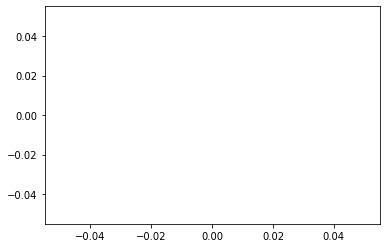

In [6]:
mass_position = np.array([1, 0, 0], dtype = float)
velocity = np.array([1, 0, 0], dtype = float)
system = spring_mass_system(1, 1, 1, mass_position, velocity)

T = 10
dt = 0.001

pos,vel = system.solve(verlet_integrate, T, dt)
t_array = np.arange(0, T, dt)
plt.plot(t_array, pos[:, 0])
#plt.plot(t_array, system.solution(t_array))

final rms error for runge_kutta is 0.0007059770472456849
final rms error for verlet_integrate is 0.0005965266492522431
final rms error for euler_integration is 0.00017272791980135253


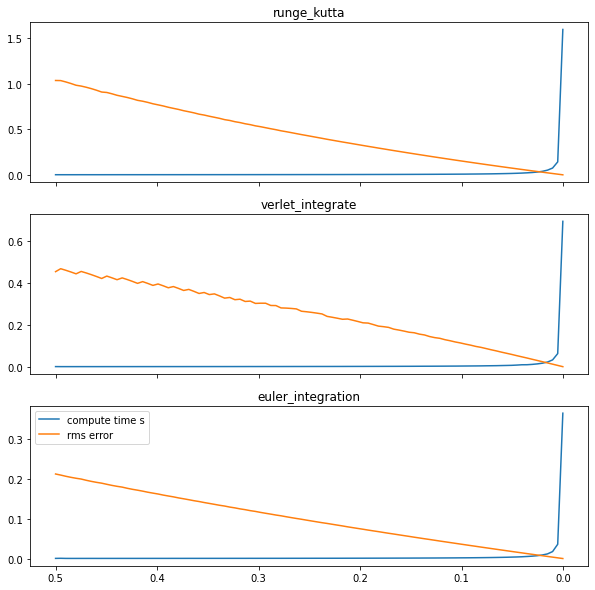

In [7]:
errors = []
solve_times = []

def test_iteration(method, dt):
  
  T = 10  
  mass_position = np.array([1, 0, 0], dtype = float)
  velocity = np.array([0, 0, 0], dtype = float)
  system = spring_mass_system(1, 1, 0, mass_position, velocity)

  pos, vel = system.solve(method, T, dt)
  t_array = np.arange(0, T, dt)
  rms_error = np.sqrt(np.mean((pos[:, 0] - system.solution(t_array)) ** 2, axis = 0))
  errors.append( rms_error )


def test_method(plot_axis, method):
  solve_times = []
  errors = []
  time_steps = np.linspace(0.5,0.0005,100)
  for dt in time_steps:
    t = %timeit -q -n1 -r1 -o test_iteration(method,dt)
    solve_times.append( t.best)

  plot_axis.plot(time_steps, solve_times, label = 'compute time s')
  plot_axis.plot(time_steps, errors, label='rms error')
  plot_axis.set_title(method.__name__)

  print(f"final rms error for {method.__name__} is {errors[-1]}")



fig, axs = plt.subplots(3, 1, figsize = (10, 10), sharex=True)

methods = [runge_kutta, verlet_integrate, euler_integration]

for m in methods:
  test_method(axs[methods.index(m)], m)

axs[0].set_xlim(axs[0].get_xlim()[::-1])

plt.legend()
plt.show()

In [8]:
G = 6.67408e-11

class solar_system():
    def __init__(self, M, m, planet_pos, planet_vel): # relative to sun
        self.M = M
        self.m = m

        self.sun = particle(M, np.zeros(3), np.zeros(3)) # coordinate system based on star
        self.planet = particle(m, planet_pos, planet_vel)
    
    def force(self, particle): # force on planet
        return -G * self.M * self.m * particle.x / np.linalg.norm(particle.x) ** 3

    def solve(self, method, t_max, dt = 0.001):
        pos,vel = method(self.planet, self.force, t_max, dt)
        return pos, vel


Scenario 1

Text(0, 0.5, 'altitude (m)')

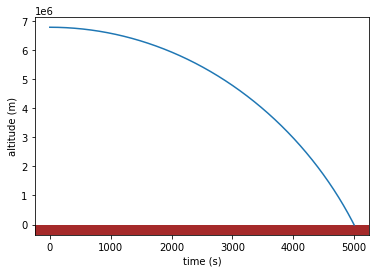

In [9]:
from matplotlib.patches import Rectangle

mars_mass = 6.42e23
mars_radius = 3.3895e6
meteor_mass = 1e3

initial_altitude = 3 * mars_radius

meteor_position = np.array([initial_altitude, 0, 0], dtype = float)
meteor_velocity = np.array([0, 0, 0], dtype = float)

meteor_planet_collision = solar_system(mars_mass, meteor_mass, meteor_position, meteor_velocity)

T = 5000
dt = 0.01
t_array = np.arange(0, T, dt)
pos, vel = meteor_planet_collision.solve(verlet_integrate, T, dt)

altidudes = np.linalg.norm(pos, axis = 1) - mars_radius

ax = plt.gca()
ax.plot(t_array, altidudes)
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.add_patch(Rectangle((x0 - .5, y0 - .5), x1 - x0, - y0, facecolor="brown"))
plt.xlabel('time (s)')
plt.ylabel('altitude (m)')

Scenario 2

Phobos orbiting mars in a circular orbit. Phobos is actually in an orbit of eccentricity 0.0151 which still looks like a circle

(-10315095.255485913,
 10315766.438185431,
 -10314512.024907852,
 10315611.015479334)

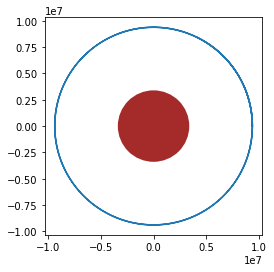

In [10]:
from matplotlib.patches import Circle

mars_mass = 6.42e23
mars_radius = 3.3895e6
phobos_mass = 1.0659e16
phobos_orbit_radius = 9.378e6

def velocity_for_circular_orbit(m1, m2, r):
    return np.sqrt(G * (m1 + m2) / r)

phobos_position = np.array([phobos_orbit_radius, 0, 0], dtype = float)
phobos_velocity = np.array([0, velocity_for_circular_orbit(mars_mass, phobos_mass, phobos_orbit_radius), 0])
mars_moons_orbit = solar_system(mars_mass, phobos_mass, phobos_position, phobos_velocity)

pos,vel = mars_moons_orbit.solve(verlet_integrate, 60000, 0.1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), mars_radius, facecolor="brown"))
ax.axis('scaled')

Scenario 3

Elliptic orbit of Bennu, an asteroid thats also a potentially hazardous object which has a high chance of impacting earth between the years 2178 - 2290.
Bennu has an orbit of eccentricity of 0.20375
The sun is also scaled up by 100x to be seen clearly

In [11]:
sun_mass = 1.989e30
sun_radius = 6.957e8
bennu_mass = 7.329e10

bennu_position = np.array([134.173e9, 0, 0])
bennu_velocity = np.array([0, 1.5*28e3, 0])

mars_moons_orbit = solar_system(sun_mass, bennu_mass, bennu_position, bennu_velocity)

pos,vel = mars_moons_orbit.solve(verlet_integrate, 1000000000, 1000)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), sun_radius * 10 ** 2, facecolor="yellow"))
ax.axis('scaled')

Scenario 4 Voyager 1 jupyter gravity jump

(-1123423646.8024297,
 521706583.86521196,
 -492240626.3629724,
 1108801154.0280957)

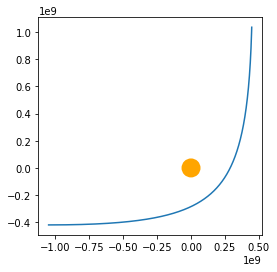

In [ ]:

jupyter_mass = 1.898e27
jupyter_radius = 6.9911e7
voyager1_mass = 825.5
voyager1_position = np.array([- 15 * jupyter_radius, - 6 * jupyter_radius, 0])
voyager1_velocity = np.array([2e4, 0, 0])

voyager1_gravity_jump = solar_system(jupyter_mass, voyager1_mass, voyager1_position, voyager1_velocity)

pos,vel = voyager1_gravity_jump.solve(verlet_integrate, 100000, 1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), jupyter_radius, facecolor="orange"))
ax.axis('scaled')

Scenario 4 part 2 hyperbolic escape from planet surface
Future Clipper spacecraft taking off from Jupyters moon Europa

(-2200974.220367052,
 11900458.627708094,
 -1908231.957275461,
 2071936.2238784838)

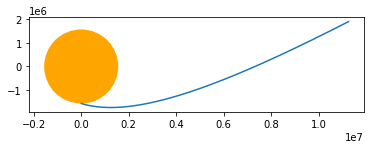

In [ ]:

europa_mass = 4.799e22
europa_radius = 1.56e6
clipper_mass = 400
clipper_position = np.array([0, - europa_radius, 0])
clipper_velocity = np.array([2e3, -6e2, 0])

clipper_hyperbolic_escape = solar_system(europa_mass, clipper_mass, clipper_position, clipper_velocity)

pos,vel = clipper_hyperbolic_escape.solve(verlet_integrate, 10000, 1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), europa_radius, facecolor="orange"))
ax.axis('scaled')